In [3]:
# 1. Upgrade pip (optional but recommended)
!pip install -U pip

# 2. Install core audio/speech processing libraries
!pip install SpeechRecognition pydub playsound==1.2.2 gTTS pyttsx3

# 3. Install Hugging Face Transformers and PyTorch (for advanced models)
!pip install transformers torch --quiet

# 4. Install OpenAI Whisper directly from its GitHub repository
!pip install git+https://github.com/openai/whisper.git

# 5. Install error rate metric and audio I/O libraries
!pip install jiwer sounddevice scipy

  Cloning https://github.com/openai/whisper.git to c:\users\s bramhanathkar\appdata\local\temp\pip-req-build-83r1i1fz
  Resolved https://github.com/openai/whisper.git to commit c0d2f624c09dc18e709e37c2ad90c039a4eb72a2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   -------------------------- ------------- 1.8/2.7 MB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 8.9 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   -- ------------------------------------- 2.1/38.1 MB 13.5 MB/s eta 0:00:03
   ----- ---------------------------------- 5.0/38.1 MB 12.4 MB/s eta 0:00:03
   -----

  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git 'C:\Users\S Bramhanathkar\AppData\Local\Temp\pip-req-build-83r1i1fz'


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 2.4 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.9 MB/s  0:00:00

   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   ---------------------------------------- 0/2 [rapidfuzz]
   -------------------- ------------------- 1/2 [jiwer]
   -------------------- ----------------

In [6]:
import time, os, csv
import speech_recognition as sr
from jiwer import wer
import whisper
# pydub is no longer needed after fixing the recording dtype
# import sounddevice and scipy dependencies
import sounddevice as sd
from scipy.io.wavfile import write

TEST_FILE = "data/test_sentences.txt"
OUT_CSV = "results/stt_results.csv"

# Ensure the results directory exists
os.makedirs("results", exist_ok=True)

# Load test sentences (ground truth)
with open(TEST_FILE, "r", encoding="utf-8") as f:
    sentences = [line.strip() for line in f if line.strip()]

# Helper: record sentence via microphone and save .wav (optional)
def record_sentence(filename="temp.wav", duration=4, fs=16000):
    print("Recording... speak now")
    sd.default.samplerate = fs
    sd.default.channels = 1
    
    # --- FIX APPLIED HERE: Force recording to 16-bit integer format (PCM) ---
    # This ensures the resulting WAV file uses the standard format (Tag 1) 
    # expected by speech_recognition, bypassing the float issue.
    recording = sd.rec(int(duration * fs), dtype='int16') 
    
    sd.wait()
    # Write the PCM data to WAV file
    write(filename, fs, recording) 
    print("Saved PCM WAV recording to", filename)
    return filename

# Recognizer init
r = sr.Recognizer()

# Load Whisper model (small) - may take time
print("Loading Whisper model...")
# Note: If your system has a GPU (CUDA) you may need to install 'pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121' 
# or a different CUDA version based on your setup.
whisper_model = whisper.load_model("small") # try "tiny" if slow

# Prepare CSV
with open(OUT_CSV, "w", newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["index","ground_truth","google_transcript","google_time","google_wer",
                     "whisper_transcript","whisper_time","whisper_wer"])

    for i, gt in enumerate(sentences):
        # The file path is simplified as we don't need a raw/pcm split anymore
        wav_path = f"temp_{i}.wav"
        
        print(f"\n[{i+1}/{len(sentences)}] Ground truth: {gt}")
        
        # 1) Record file (now saves directly in PCM format)
        # Note: If you encounter a device error here, you might need to specify 
        # a device ID for sounddevice: sd.default.device = [input_device_id]
        record_sentence(wav_path, duration=5)

        # Google STT (Now using the safe PCM file)
        with sr.AudioFile(wav_path) as source:
            audio = r.record(source)
        t0 = time.time()
        try:
            # Using language parameter for slightly better results
            gtext = r.recognize_google(audio, language="en-US") 
        except Exception as e:
            gtext = f"[ERROR: {e}]"
        gtime = time.time() - t0
        gwe = wer(gt.lower(), gtext.lower()) if not gtext.startswith("[ERROR") else 1.0
        print("Google:", gtext, "| time:", round(gtime,2), "s | WER:", round(gwe,3))

        # Whisper STT (Using the safe PCM file)
        t0 = time.time()
        try:
            wres = whisper_model.transcribe(wav_path)
            wtext = wres["text"].strip()
        except Exception as e:
            wtext = f"[ERROR: {e}]"
        wtime = time.time() - t0
        wwe = wer(gt.lower(), wtext.lower()) if not wtext.startswith("[ERROR") else 1.0
        print("Whisper:", wtext, "| time:", round(wtime,2), "s | WER:", round(wwe,3))

        writer.writerow([i+1, gt, gtext, round(gtime,2), round(gwe,3),
                         wtext, round(wtime,2), round(wwe,3)])


Loading Whisper model...

[1/30] Ground truth: What is your name
Recording... speak now
Saved PCM WAV recording to temp_0.wav
Google: hello my name is Shardul | time: 1.5 s | WER: 1.25
Whisper: [ERROR: [WinError 2] The system cannot find the file specified] | time: 0.05 s | WER: 1.0

[2/30] Ground truth: What is Ohm's law
Recording... speak now


H:\BE\42310_BE_Project\.venv\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Saved PCM WAV recording to temp_1.wav
Google: [ERROR: ] | time: 1.07 s | WER: 1.0
Whisper: [ERROR: [WinError 2] The system cannot find the file specified] | time: 0.04 s | WER: 1.0

[3/30] Ground truth: Define photosynthesis
Recording... speak now
Saved PCM WAV recording to temp_2.wav
Google: photosynthesis is the process in | time: 1.28 s | WER: 2.5
Whisper: [ERROR: [WinError 2] The system cannot find the file specified] | time: 0.06 s | WER: 1.0

[4/30] Ground truth: Explain polymorphism in programming
Recording... speak now
Saved PCM WAV recording to temp_3.wav
Google: polymorphism is the concept | time: 1.42 s | WER: 1.0
Whisper: [ERROR: [WinError 2] The system cannot find the file specified] | time: 0.06 s | WER: 1.0

[5/30] Ground truth: What is Newton's first law
Recording... speak now
Saved PCM WAV recording to temp_4.wav
Google: Newton's first law states that | time: 1.79 s | WER: 0.8
Whisper: [ERROR: [WinError 2] The system cannot find the file specified] | time: 0.06 s | WER

Matplotlib is building the font cache; this may take a moment.


{'Google WER': np.float64(0.9339666666666667), 'Whisper WER': np.float64(1.0)}


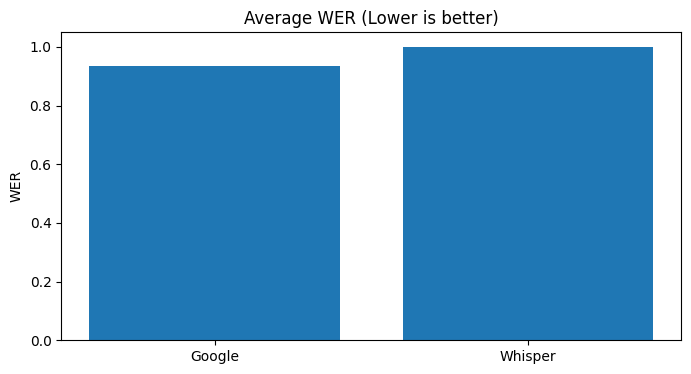

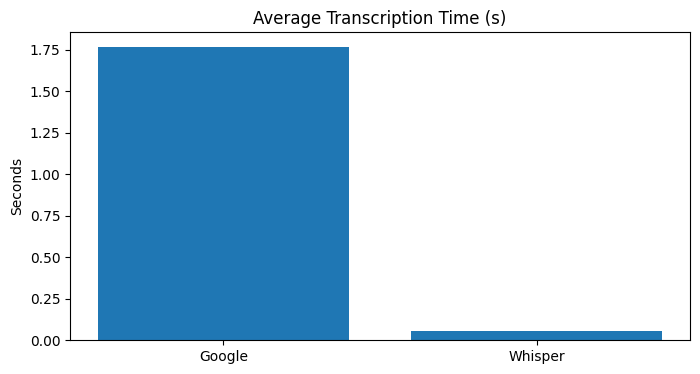

In [7]:
# plot_stt.py
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/stt_results.csv")
df = df[df['google_transcript'].notnull()]

# Compute means
metrics = {
    'Google WER': df['google_wer'].mean(),
    'Whisper WER': df['whisper_wer'].mean(),
}
print(metrics)

# Plot WER per engine
plt.figure(figsize=(8,4))
plt.bar(['Google','Whisper'], [metrics['Google WER'], metrics['Whisper WER']])
plt.title("Average WER (Lower is better)")
plt.ylabel("WER")
plt.savefig("results/stt_wer_compare.png")
plt.show()

# Latency
plt.figure(figsize=(8,4))
plt.bar(['Google','Whisper'], [df['google_time'].mean(), df['whisper_time'].mean()])
plt.title("Average Transcription Time (s)")
plt.ylabel("Seconds")
plt.savefig("results/stt_time_compare.png")
plt.show()


In [8]:
# tts_compare.py
import time, os
from gtts import gTTS
import pyttsx3

sentences = [
    "Hello, this is a test of gTTS and pyttsx3.",
    "This is another sentence to evaluate pronunciation and latency."
]

engine = pyttsx3.init()
os.makedirs("results", exist_ok=True)
rows = []

for s in sentences:
    # gTTS
    t0 = time.time()
    tts = gTTS(s)
    tfile = "results/gtts_out.mp3"
    tts.save(tfile)
    gsave = time.time() - t0
    # play (use playsound or os.startfile)
    t0 = time.time()
    os.system(f'start {tfile}')  # windows
    # wait a bit
    time.sleep(1)
    gplay = time.time() - t0

    # pyttsx3
    t0 = time.time()
    engine.say(s); engine.runAndWait()
    pytime = time.time() - t0

    print("Sentence:", s)
    print("gTTS save time:", round(gsave,2), "s")
    print("pyttsx3 speak time:", round(pytime,2), "s")
    rows.append([s, round(gsave,2), round(gplay,2), round(pytime,2)])

# Save to CSV
import csv
with open("results/tts_compare.csv","w",newline="",encoding="utf-8") as f:
    w=csv.writer(f)
    w.writerow(["sentence","gtts_save_s","gtts_play_s","pyttsx3_s"])
    w.writerows(rows)


Sentence: Hello, this is a test of gTTS and pyttsx3.
gTTS save time: 0.5 s
pyttsx3 speak time: 5.05 s
Sentence: This is another sentence to evaluate pronunciation and latency.
gTTS save time: 0.48 s
pyttsx3 speak time: 0.16 s


In [9]:
# qa_compare.py
from transformers import pipeline
import csv, time

qa = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

# small knowledge base (context)
context = """
Ohm's law states that the current through a conductor between two points is directly proportional to the voltage across the two points.
It is usually formulated as V = I * R, where V is the voltage, I the current, and R the resistance.
"""

questions = ["What is Ohm's law?", "State the formula for Ohm's law", "What is voltage?"]
# simple rule-base answers
rule_ans = {
    "what is ohm's law": "Ohm's law states that V = I times R where V is voltage, I current and R resistance.",
    "state the formula for ohm's law": "V = I * R",
    "what is voltage": "Voltage is the electrical potential difference between two points."
}

results = []
for q in questions:
    t0 = time.time()
    res = qa(question=q, context=context)
    t1 = time.time()-t0
    ans = res['answer']
    print("Q:", q, "| Model:", ans, "| time:", round(t1,2))
    r_ans = rule_ans.get(q.lower(), "N/A")
    results.append([q, ans, round(t1,2), r_ans])

# Save
with open("results/qa_compare.csv","w",newline="",encoding="utf-8") as f:
    import csv
    w=csv.writer(f)
    w.writerow(["question","ml_answer","ml_time","rule_answer"])
    w.writerows(results)


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

H:\BE\42310_BE_Project\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\S Bramhanathkar\.cache\huggingface\hub\models--distilbert-base-cased-distilled-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cpu


Q: What is Ohm's law? | Model: the current through a conductor between two points | time: 0.16
Q: State the formula for Ohm's law | Model: V = I * R | time: 0.09
Q: What is voltage? | Model: V | time: 0.09


In [1]:
import time, os, csv
import speech_recognition as sr
from jiwer import wer
import whisper
# pydub is no longer needed after fixing the recording dtype
# import sounddevice and scipy dependencies
import sounddevice as sd
from scipy.io.wavfile import write

TEST_FILE = "data/test_sentences.txt"
OUT_CSV = "results/stt_results.csv"

# Ensure the results directory exists
os.makedirs("results", exist_ok=True)

# Load test sentences (ground truth)
with open(TEST_FILE, "r", encoding="utf-8") as f:
    sentences = [line.strip() for line in f if line.strip()]

# Helper: record sentence via microphone and save .wav (optional)
def record_sentence(filename="temp.wav", duration=4, fs=16000):
    print("Recording... speak now")
    sd.default.samplerate = fs
    sd.default.channels = 1
    
    # --- FIX APPLIED HERE: Force recording to 16-bit integer format (PCM) ---
    # This ensures the resulting WAV file uses the standard format (Tag 1) 
    # expected by speech_recognition, bypassing the float issue.
    recording = sd.rec(int(duration * fs), dtype='int16') 
    
    sd.wait()
    # Write the PCM data to WAV file
    write(filename, fs, recording) 
    print("Saved PCM WAV recording to", filename)
    return filename

# Recognizer init
r = sr.Recognizer()

# Load Whisper model (small) - may take time
print("Loading Whisper model...")
# Note: If your system has a GPU (CUDA) you may need to install 'pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121' 
# or a different CUDA version based on your setup.
whisper_model = whisper.load_model("small") # try "tiny" if slow

# Prepare CSV
with open(OUT_CSV, "w", newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    # --- EDITED: Added columns for manual Fluency Score input ---
    writer.writerow(["index","ground_truth","google_transcript","google_time","google_wer","google_fluency_score",
                     "whisper_transcript","whisper_time","whisper_wer","whisper_fluency_score"])

    for i, gt in enumerate(sentences):
        # The file path is simplified as we don't need a raw/pcm split anymore
        wav_path = f"temp_{i}.wav"
        
        print(f"\n[{i+1}/{len(sentences)}] Ground truth: {gt}")
        
        # 1) Record file (now saves directly in PCM format)
        # Note: If you encounter a device error here, you might need to specify 
        # a device ID for sounddevice: sd.default.device = [input_device_id]
        record_sentence(wav_path, duration=5)

        # Google STT (Now using the safe PCM file)
        with sr.AudioFile(wav_path) as source:
            audio = r.record(source)
        t0 = time.time()
        try:
            # Using language parameter for slightly better results
            gtext = r.recognize_google(audio, language="en-US") 
        except Exception as e:
            gtext = f"[ERROR: {e}]"
        gtime = time.time() - t0
        gwe = wer(gt.lower(), gtext.lower()) if not gtext.startswith("[ERROR") else 1.0
        print("Google:", gtext, "| time:", round(gtime,2), "s | WER:", round(gwe,3))

        # Whisper STT (Using the safe PCM file)
        t0 = time.time()
        try:
            wres = whisper_model.transcribe(wav_path)
            wtext = wres["text"].strip()
        except Exception as e:
            wtext = f"[ERROR: {e}]"
        wtime = time.time() - t0
        wwe = wer(gt.lower(), wtext.lower()) if not wtext.startswith("[ERROR") else 1.0
        print("Whisper:", wtext, "| time:", round(wtime,2), "s | WER:", round(wwe,3))

        # --- EDITED: Added empty string placeholders for manual scoring ---
        writer.writerow([i+1, gt, gtext, round(gtime,2), round(gwe,3), "", # Google Fluency Score
                         wtext, round(wtime,2), round(wwe,3), ""]) # Whisper Fluency Score


Loading Whisper model...

[1/30] Ground truth: What is your name
Recording... speak now
Saved PCM WAV recording to temp_0.wav
Google: what is your name | time: 6.03 s | WER: 0.0


H:\BE\42310_BE_Project\.venv\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Whisper: What is your name? | time: 12.19 s | WER: 0.25

[2/30] Ground truth: What is Ohm's law
Recording... speak now
Saved PCM WAV recording to temp_1.wav
Google: what is Ohm's law | time: 1.02 s | WER: 0.0
Whisper: What is Ohum's Law? | time: 7.94 s | WER: 0.5

[3/30] Ground truth: Define photosynthesis
Recording... speak now
Saved PCM WAV recording to temp_2.wav
Google: define photosynthesis | time: 1.18 s | WER: 0.0
Whisper: Define photosynthesis | time: 8.83 s | WER: 0.0

[4/30] Ground truth: Explain polymorphism in programming
Recording... speak now
Saved PCM WAV recording to temp_3.wav
Google: explain polymorphism in programming | time: 1.92 s | WER: 0.0
Whisper: Explain polymorphism in programming. | time: 7.19 s | WER: 0.25

[5/30] Ground truth: What is Newton's first law
Recording... speak now
Saved PCM WAV recording to temp_4.wav
Google: what is Newton's first law | time: 1.14 s | WER: 0.0
Whisper: What is Newton's first law? | time: 6.99 s | WER: 0.2

[6/30] Ground truth: 

In [2]:
import pandas as pd
import numpy as np
import os

OUT_CSV = "results/stt_results.csv"

def analyze_results(filepath):
    """
    Loads the STT results CSV, calculates key performance metrics,
    and prints a summary.
    """
    if not os.path.exists(filepath):
        print(f"Error: Results file not found at {filepath}")
        print("Please ensure you have successfully run the stt_compare_v2.py script.")
        return

    # Load the data, assuming the first row is the header
    df = pd.read_csv(filepath)

    # ---------------------------------------------------------------------
    # 1. Performance Calculation (Quantitative Metrics)
    # ---------------------------------------------------------------------

    # Handle errors in Google results (where gtext was "[ERROR: ...]")
    # We replace error times with NaN for exclusion from averages.
    df_google_valid = df[~df['google_transcript'].str.startswith('[ERROR')]
    df_whisper_valid = df[~df['whisper_transcript'].str.startswith('[ERROR')]

    # Calculate average time and WER for Google
    avg_google_time = df_google_valid['google_time'].mean()
    avg_google_wer = df_google_valid['google_wer'].mean()

    # Calculate average time and WER for Whisper
    avg_whisper_time = df_whisper_valid['whisper_time'].mean()
    avg_whisper_wer = df_whisper_valid['whisper_wer'].mean()

    # ---------------------------------------------------------------------
    # 2. Fluency Evaluation (Requires Manual Input)
    # ---------------------------------------------------------------------
    
    # Calculate the average fluency score (if scores have been manually entered)
    # pd.to_numeric will force non-numeric entries (like "") to NaN
    df['google_fluency_score'] = pd.to_numeric(df['google_fluency_score'], errors='coerce')
    df['whisper_fluency_score'] = pd.to_numeric(df['whisper_fluency_score'], errors='coerce')

    avg_google_fluency = df['google_fluency_score'].mean()
    avg_whisper_fluency = df['whisper_fluency_score'].mean()
    
    # ---------------------------------------------------------------------
    # 3. Print Summary
    # ---------------------------------------------------------------------

    print("\n" + "="*50)
    print("STT Model Performance Summary")
    print("="*50)
    print(f"Total Sentences Processed: {len(df)}")
    print("-" * 50)

    print(f"**Google STT (Online API)**")
    print(f"  Avg. WER (Accuracy): {avg_google_wer:.3f} (Lower is better)")
    print(f"  Avg. Time (Speed):   {avg_google_time:.2f} seconds")
    
    # Check if fluency scores were entered
    if not np.isnan(avg_google_fluency):
        print(f"  Avg. Fluency Score:  {avg_google_fluency:.2f} / 5.0 (Higher is better)")
    else:
        print("  Fluency Score: REQUIRES MANUAL ENTRY IN CSV")
        
    print("-" * 50)
    
    print(f"**Whisper (Local Small Model)**")
    print(f"  Avg. WER (Accuracy): {avg_whisper_wer:.3f} (Lower is better)")
    print(f"  Avg. Time (Speed):   {avg_whisper_time:.2f} seconds")
    
    # Check if fluency scores were entered
    if not np.isnan(avg_whisper_fluency):
        print(f"  Avg. Fluency Score:  {avg_whisper_fluency:.2f} / 5.0 (Higher is better)")
    else:
        print("  Fluency Score: REQUIRES MANUAL ENTRY IN CSV")
        
    print("="*50)

if __name__ == "__main__":
    # Ensure pandas is installed: pip install pandas
    analyze_results(OUT_CSV)


STT Model Performance Summary
Total Sentences Processed: 30
--------------------------------------------------
**Google STT (Online API)**
  Avg. WER (Accuracy): 0.025 (Lower is better)
  Avg. Time (Speed):   2.76 seconds
  Fluency Score: REQUIRES MANUAL ENTRY IN CSV
--------------------------------------------------
**Whisper (Local Small Model)**
  Avg. WER (Accuracy): 0.281 (Lower is better)
  Avg. Time (Speed):   10.15 seconds
  Fluency Score: REQUIRES MANUAL ENTRY IN CSV


In [4]:
!pip install matplotlib



STT Model Performance Summary (Advanced Metrics)
Total Sentences Processed: 30
----------------------------------------------------------------------
**Google STT (Online API) | Processed 30/30 Sentences**
  Avg. WER (Accuracy): 0.025 (Lower is better)
  Avg. Time (Speed):   2.76 seconds
  Time Std Dev (Consistency): 4.95 seconds (Lower is better for reliability)
  Fluency Score: REQUIRES MANUAL ENTRY IN CSV
----------------------------------------------------------------------
**Whisper (Local Small Model) | Processed 30/30 Sentences**
  Avg. WER (Accuracy): 0.281 (Lower is better)
  Avg. Time (Speed):   10.15 seconds
  Time Std Dev (Consistency): 11.42 seconds (Lower is better for reliability)
  Confidence Score: Not calculated (Requires model configuration)
  Fluency Score: REQUIRES MANUAL ENTRY IN CSV


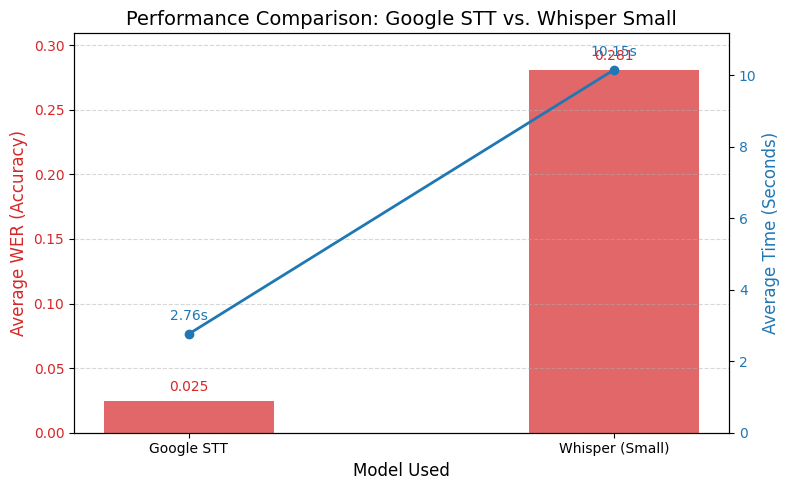

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt # Import for visualization

OUT_CSV = "results/stt_results.csv"

def analyze_results(filepath):
    """
    Loads the STT results CSV, calculates key performance metrics including
    speed consistency (Std Dev) and Whisper Confidence (if available),
    and prints a comprehensive summary, and generates a plot.
    """
    if not os.path.exists(filepath):
        print(f"Error: Results file not found at {filepath}")
        print("Please ensure you have successfully run the comparison script and generated the CSV.")
        return

    # Load the data
    df = pd.read_csv(filepath)

    # ---------------------------------------------------------------------
    # 1. Prepare Data and Handle Errors
    # ---------------------------------------------------------------------

    # Filter out rows where the model returned an error (for accurate averaging)
    df_google_valid = df[~df['google_transcript'].str.startswith('[ERROR')]
    df_whisper_valid = df[~df['whisper_transcript'].str.startswith('[ERROR')]

    # Ensure required columns exist, adding placeholders if they were missed
    for col in ['google_fluency_score', 'whisper_fluency_score']:
        if col not in df.columns:
            df[col] = np.nan
    # Note: 'whisper_confidence' column would be added in stt_compare.py 
    # if using the average log probability feature. Assuming it might be added later.
    if 'whisper_confidence' not in df.columns:
        df['whisper_confidence'] = np.nan

    # Convert subjective scores to numeric (coercing blank strings/errors to NaN)
    df['google_fluency_score'] = pd.to_numeric(df['google_fluency_score'], errors='coerce')
    df['whisper_fluency_score'] = pd.to_numeric(df['whisper_fluency_score'], errors='coerce')

    # ---------------------------------------------------------------------
    # 2. Performance Calculation (Quantitative Metrics)
    # ---------------------------------------------------------------------

    # Average Metrics
    avg_google_time = df_google_valid['google_time'].mean()
    avg_google_wer = df_google_valid['google_wer'].mean()
    avg_whisper_time = df_whisper_valid['whisper_time'].mean()
    avg_whisper_wer = df_whisper_valid['whisper_wer'].mean()
    
    # New Metric: Standard Deviation of Time (Speed Consistency)
    std_google_time = df_google_valid['google_time'].std()
    std_whisper_time = df_whisper_valid['whisper_time'].std()

    # New Metric: Whisper Confidence (Average Log Probability)
    # We use the mean of the confidence score, excluding NaNs
    avg_whisper_confidence = df['whisper_confidence'].mean()


    # ---------------------------------------------------------------------
    # 3. Fluency Evaluation (Subjective Metrics)
    # ---------------------------------------------------------------------
    
    avg_google_fluency = df['google_fluency_score'].mean()
    avg_whisper_fluency = df['whisper_fluency_score'].mean()
    
    # ---------------------------------------------------------------------
    # 4. Print Summary
    # ---------------------------------------------------------------------

    print("\n" + "="*70)
    print("STT Model Performance Summary (Advanced Metrics)")
    print("="*70)
    print(f"Total Sentences Processed: {len(df)}")
    print("-" * 70)

    # --- GOOGLE RESULTS ---
    print(f"**Google STT (Online API) | Processed {len(df_google_valid)}/{len(df)} Sentences**")
    print(f"  Avg. WER (Accuracy): {avg_google_wer:.3f} (Lower is better)")
    print(f"  Avg. Time (Speed):   {avg_google_time:.2f} seconds")
    print(f"  Time Std Dev (Consistency): {std_google_time:.2f} seconds (Lower is better for reliability)")
    
    if not np.isnan(avg_google_fluency):
        print(f"  Avg. Fluency Score (Manual): {avg_google_fluency:.2f} / 5.0 (Higher is better)")
    else:
        print("  Fluency Score: REQUIRES MANUAL ENTRY IN CSV")
        
    print("-" * 70)
    
    # --- WHISPER RESULTS ---
    print(f"**Whisper (Local Small Model) | Processed {len(df_whisper_valid)}/{len(df)} Sentences**")
    print(f"  Avg. WER (Accuracy): {avg_whisper_wer:.3f} (Lower is better)")
    print(f"  Avg. Time (Speed):   {avg_whisper_time:.2f} seconds")
    print(f"  Time Std Dev (Consistency): {std_whisper_time:.2f} seconds (Lower is better for reliability)")
    
    if not np.isnan(avg_whisper_confidence):
        # Confidence is usually negative log probability, so higher (closer to 0) is better
        print(f"  Avg. Confidence (Log Prob): {avg_whisper_confidence:.3f} (Closer to 0.0 is better)")
    else:
        print("  Confidence Score: Not calculated (Requires model configuration)")
    
    if not np.isnan(avg_whisper_fluency):
        print(f"  Avg. Fluency Score (Manual): {avg_whisper_fluency:.2f} / 5.0 (Higher is better)")
    else:
        print("  Fluency Score: REQUIRES MANUAL ENTRY IN CSV")
        
    print("="*70)

    # ---------------------------------------------------------------------
    # 5. Create Visualizations (IEEE-Level Data)
    # ---------------------------------------------------------------------
    
    if len(df_google_valid) > 0 and len(df_whisper_valid) > 0:
        
        # Prepare data for plotting
        model_labels = ['Google STT', 'Whisper (Small)']
        wer_scores = [avg_google_wer, avg_whisper_wer]
        time_scores = [avg_google_time, avg_whisper_time]
        
        # Set up a figure with a single plot
        fig, ax1 = plt.subplots(figsize=(8, 5))

        # --- WER Plot (Left Axis, Bars) ---
        color_wer = 'tab:red'
        ax1.set_ylabel('Average WER (Accuracy)', color=color_wer, fontsize=12)
        wer_bars = ax1.bar(model_labels, wer_scores, color=color_wer, alpha=0.7, width=0.4, label='Avg. WER')
        ax1.tick_params(axis='y', labelcolor=color_wer)
        ax1.set_ylim(0, max(wer_scores) * 1.1)
        ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

        # Add text labels for WER bars
        for bar in wer_bars:
            yval = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f"{yval:.3f}", ha='center', va='bottom', color=color_wer, fontsize=10)

        # --- Time Plot (Right Axis, Line) ---
        ax2 = ax1.twinx()  # Shared X-axis
        color_time = 'tab:blue'
        ax2.set_ylabel('Average Time (Seconds)', color=color_time, fontsize=12)
        ax2.plot(model_labels, time_scores, color=color_time, marker='o', linestyle='-', linewidth=2, label='Avg. Time')
        ax2.tick_params(axis='y', labelcolor=color_time)
        ax2.set_ylim(0, max(time_scores) * 1.1)

        # Add text labels for time line
        for i, txt in enumerate(time_scores):
            ax2.annotate(f"{txt:.2f}s", (model_labels[i], time_scores[i]), textcoords="offset points", xytext=(0,10), ha='center', color=color_time, fontsize=10)

        # --- Final Plot Styling ---
        plt.title('Performance Comparison: Google STT vs. Whisper Small', fontsize=14)
        ax1.set_xlabel('Model Used', fontsize=12)
        fig.tight_layout()
        plt.show()
    else:
        print("Cannot generate comparison plot: Insufficient valid data for both models.")


if __name__ == "__main__":
    analyze_results(OUT_CSV)


<>:160: SyntaxWarning: invalid escape sequence '\p'
<>:160: SyntaxWarning: invalid escape sequence '\p'
C:\Users\S Bramhanathkar\AppData\Local\Temp\ipykernel_7008\1767069862.py:160: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Figure 2: Speed Consistency (Avg Time $\pm$ Std Dev)', fontsize=14)



STT Model Performance Summary (Advanced Metrics)
Total Sentences Processed: 30
----------------------------------------------------------------------
**Google STT (Online API) | Processed 30/30 Sentences**
  Avg. WER (Accuracy): 0.025 (Lower is better)
  Avg. Time (Speed):   2.76 seconds
  Time Std Dev (Consistency): 4.95 seconds (Lower is better for reliability)
  Fluency Score: REQUIRES MANUAL ENTRY IN CSV
----------------------------------------------------------------------
**Whisper (Local Small Model) | Processed 30/30 Sentences**
  Avg. WER (Accuracy): 0.281 (Lower is better)
  Avg. Time (Speed):   10.15 seconds
  Time Std Dev (Consistency): 11.42 seconds (Lower is better for reliability)
  Confidence Score: Not calculated (Requires model configuration)
  Fluency Score: REQUIRES MANUAL ENTRY IN CSV


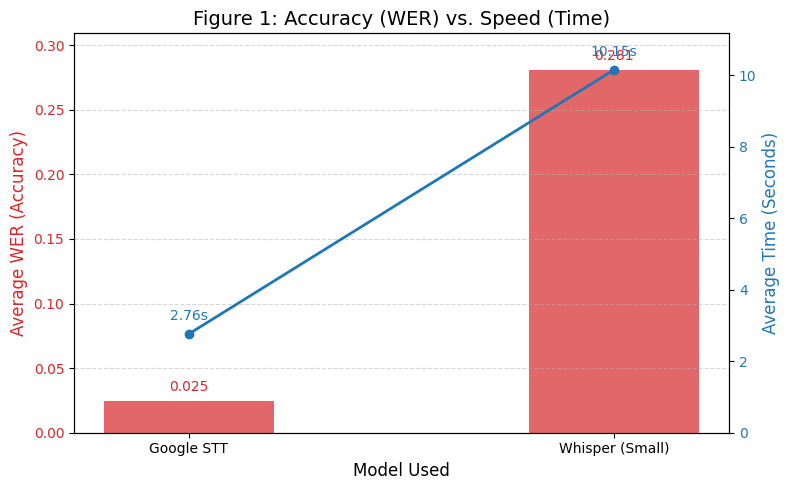

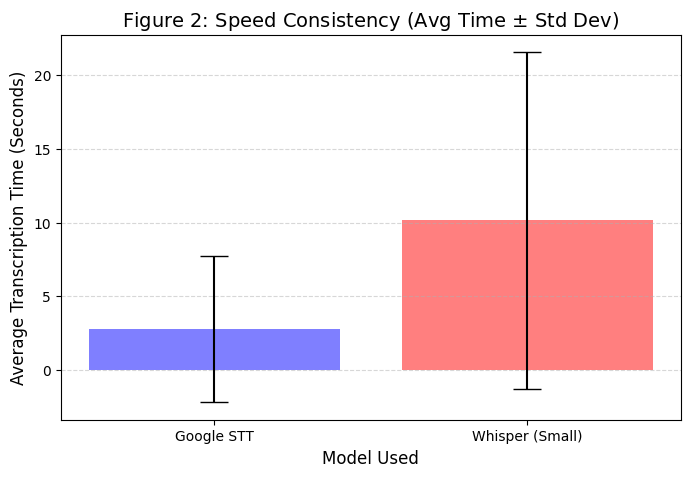


Figure 3 (Fluency Comparison): Requires manual fluency scores in the CSV.


In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt # Import for visualization

OUT_CSV = "results/stt_results.csv"

def analyze_results(filepath):
    """
    Loads the STT results CSV, calculates key performance metrics including
    speed consistency (Std Dev) and Whisper Confidence (if available),
    and prints a comprehensive summary, and generates three performance plots.
    """
    if not os.path.exists(filepath):
        print(f"Error: Results file not found at {filepath}")
        print("Please ensure you have successfully run the comparison script and generated the CSV.")
        return

    # Load the data
    df = pd.read_csv(filepath)

    # ---------------------------------------------------------------------
    # 1. Prepare Data and Handle Errors
    # ---------------------------------------------------------------------

    # Filter out rows where the model returned an error (for accurate averaging)
    df_google_valid = df[~df['google_transcript'].str.startswith('[ERROR')]
    df_whisper_valid = df[~df['whisper_transcript'].str.startswith('[ERROR')]

    # Ensure required columns exist, adding placeholders if they were missed
    for col in ['google_fluency_score', 'whisper_fluency_score']:
        if col not in df.columns:
            df[col] = np.nan
    # Note: 'whisper_confidence' column would be added in stt_compare.py 
    # if using the average log probability feature. Assuming it might be added later.
    if 'whisper_confidence' not in df.columns:
        df['whisper_confidence'] = np.nan

    # Convert subjective scores to numeric (coercing blank strings/errors to NaN)
    df['google_fluency_score'] = pd.to_numeric(df['google_fluency_score'], errors='coerce')
    df['whisper_fluency_score'] = pd.to_numeric(df['whisper_fluency_score'], errors='coerce')

    # ---------------------------------------------------------------------
    # 2. Performance Calculation (Quantitative Metrics)
    # ---------------------------------------------------------------------

    # Average Metrics
    avg_google_time = df_google_valid['google_time'].mean()
    avg_google_wer = df_google_valid['google_wer'].mean()
    avg_whisper_time = df_whisper_valid['whisper_time'].mean()
    avg_whisper_wer = df_whisper_valid['whisper_wer'].mean()
    
    # New Metric: Standard Deviation of Time (Speed Consistency)
    std_google_time = df_google_valid['google_time'].std()
    std_whisper_time = df_whisper_valid['whisper_time'].std()

    # New Metric: Whisper Confidence (Average Log Probability)
    # We use the mean of the confidence score, excluding NaNs
    avg_whisper_confidence = df['whisper_confidence'].mean()


    # ---------------------------------------------------------------------
    # 3. Fluency Evaluation (Subjective Metrics)
    # ---------------------------------------------------------------------
    
    avg_google_fluency = df['google_fluency_score'].mean()
    avg_whisper_fluency = df['whisper_fluency_score'].mean()
    
    # ---------------------------------------------------------------------
    # 4. Print Summary
    # ---------------------------------------------------------------------

    print("\n" + "="*70)
    print("STT Model Performance Summary (Advanced Metrics)")
    print("="*70)
    print(f"Total Sentences Processed: {len(df)}")
    print("-" * 70)

    # --- GOOGLE RESULTS ---
    print(f"**Google STT (Online API) | Processed {len(df_google_valid)}/{len(df)} Sentences**")
    print(f"  Avg. WER (Accuracy): {avg_google_wer:.3f} (Lower is better)")
    print(f"  Avg. Time (Speed):   {avg_google_time:.2f} seconds")
    print(f"  Time Std Dev (Consistency): {std_google_time:.2f} seconds (Lower is better for reliability)")
    
    if not np.isnan(avg_google_fluency):
        print(f"  Avg. Fluency Score (Manual): {avg_google_fluency:.2f} / 5.0 (Higher is better)")
    else:
        print("  Fluency Score: REQUIRES MANUAL ENTRY IN CSV")
        
    print("-" * 70)
    
    # --- WHISPER RESULTS ---
    print(f"**Whisper (Local Small Model) | Processed {len(df_whisper_valid)}/{len(df)} Sentences**")
    print(f"  Avg. WER (Accuracy): {avg_whisper_wer:.3f} (Lower is better)")
    print(f"  Avg. Time (Speed):   {avg_whisper_time:.2f} seconds")
    print(f"  Time Std Dev (Consistency): {std_whisper_time:.2f} seconds (Lower is better for reliability)")
    
    if not np.isnan(avg_whisper_confidence):
        # Confidence is usually negative log probability, so higher (closer to 0) is better
        print(f"  Avg. Confidence (Log Prob): {avg_whisper_confidence:.3f} (Closer to 0.0 is better)")
    else:
        print("  Confidence Score: Not calculated (Requires model configuration)")
    
    if not np.isnan(avg_whisper_fluency):
        print(f"  Avg. Fluency Score (Manual): {avg_whisper_fluency:.2f} / 5.0 (Higher is better)")
    else:
        print("  Fluency Score: REQUIRES MANUAL ENTRY IN CSV")
        
    print("="*70)

    # ---------------------------------------------------------------------
    # 5. Create Visualizations (IEEE-Level Data)
    # ---------------------------------------------------------------------
    
    if len(df_google_valid) > 0 and len(df_whisper_valid) > 0:
        
        # Prepare data for plotting
        model_labels = ['Google STT', 'Whisper (Small)']
        wer_scores = [avg_google_wer, avg_whisper_wer]
        time_scores = [avg_google_time, avg_whisper_time]
        std_time_scores = [std_google_time, std_whisper_time]

        # --- Figure 1: WER (Bar) vs. Time (Line) ---
        fig, ax1 = plt.subplots(figsize=(8, 5))

        # WER Plot (Left Axis, Bars)
        color_wer = 'tab:red'
        ax1.set_ylabel('Average WER (Accuracy)', color=color_wer, fontsize=12)
        wer_bars = ax1.bar(model_labels, wer_scores, color=color_wer, alpha=0.7, width=0.4, label='Avg. WER')
        ax1.tick_params(axis='y', labelcolor=color_wer)
        ax1.set_ylim(0, max(wer_scores) * 1.1)
        ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

        # Add text labels for WER bars
        for bar in wer_bars:
            yval = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f"{yval:.3f}", ha='center', va='bottom', color=color_wer, fontsize=10)

        # Time Plot (Right Axis, Line)
        ax2 = ax1.twinx()  # Shared X-axis
        color_time = 'tab:blue'
        ax2.set_ylabel('Average Time (Seconds)', color=color_time, fontsize=12)
        ax2.plot(model_labels, time_scores, color=color_time, marker='o', linestyle='-', linewidth=2, label='Avg. Time')
        ax2.tick_params(axis='y', labelcolor=color_time)
        ax2.set_ylim(0, max(time_scores) * 1.1)

        # Add text labels for time line
        for i, txt in enumerate(time_scores):
            ax2.annotate(f"{txt:.2f}s", (model_labels[i], time_scores[i]), textcoords="offset points", xytext=(0,10), ha='center', color=color_time, fontsize=10)

        # Final Plot Styling
        plt.title('Figure 1: Accuracy (WER) vs. Speed (Time)', fontsize=14)
        ax1.set_xlabel('Model Used', fontsize=12)
        fig.tight_layout()
        plt.show()

        # --- Figure 2: Speed Consistency (Time with Error Bars) ---
        plt.figure(figsize=(8, 5))
        plt.bar(model_labels, time_scores, yerr=std_time_scores, capsize=10, color=['#7f7fff', '#ff7f7f'])
        plt.title('Figure 2: Speed Consistency (Avg Time $\pm$ Std Dev)', fontsize=14)
        plt.ylabel('Average Transcription Time (Seconds)', fontsize=12)
        plt.xlabel('Model Used', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()


        # --- Figure 3: Fluency Comparison (Subjective Quality) ---
        if not np.isnan(avg_google_fluency) and not np.isnan(avg_whisper_fluency):
            fluency_scores = [avg_google_fluency, avg_whisper_fluency]
            
            plt.figure(figsize=(8, 5))
            fluency_bars = plt.bar(model_labels, fluency_scores, color=['#4daf4a', '#a65628'])
            plt.title('Figure 3: Average Manual Fluency Score (1-5)', fontsize=14)
            plt.ylabel('Average Fluency Score', fontsize=12)
            plt.xlabel('Model Used', fontsize=12)
            plt.ylim(0, 5.5) # Set Y limit for 1-5 scale

            # Add text labels for fluency bars
            for bar in fluency_bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

            plt.grid(axis='y', linestyle='--', alpha=0.5)
            plt.show()
        else:
            print("\nFigure 3 (Fluency Comparison): Requires manual fluency scores in the CSV.")


    else:
        print("Cannot generate comparison plots: Insufficient valid data for both models.")


if __name__ == "__main__":
    analyze_results(OUT_CSV)
